## Here I will write some scripts to automatically filter alignments to the new genome, and then use these to map Christophe's hybrid zone cline tags to the genome. 

In [213]:
from __future__ import division

In [269]:
def summarise_alignments(alignments_path, log_handle):
    
    from Bio.Blast import NCBIXML
    
    blast_alignments = NCBIXML.parse(open(alignments_path, 'r'))
    
    logfile = log_handle
    logfile.write("\nAlignments parsed, summarising hits, filtering no-hit and multi-good-hit markers . . . \n")
    
    
    print "Alignments parsed"
    print "Filtering no-hit and multi-good-hit markers"
    
    print "\n### Summarising hits . . . "
    
    unique_alignments = []
    two_alignments_only = []
    multi_alignments = []
    
    one_best_alignment = []
    two_best_alignments = []
    more_than_two_best = []
    
    dict_to_keep = {}
    dict_to_keep["One_good_hit"] = []
    dict_to_keep["Two_good_hits"] = []
    
    discarded = {}
    
    eval_diff_thresh = 1e-5
    
    alignment_counter = 0
    
    for record in blast_alignments:
        
        alignment_counter += 1
        
        if len(record.alignments) == 1:
            
            if record.alignments[0].hsps[0].expect < 1e-20:
            
                unique_alignments.append(record.query)
                dict_to_keep["One_good_hit"].append(record)
                
            else:
                discarded[record.query] = "No hits with e-val < 1e-20"
            
            
        elif len(record.alignments) == 2:
            
            two_alignments_only.append(record.query)
            
            if record.alignments[0].hsps[0].expect < 1e-20:
                
                if all([record.alignments[1].hsps[0].expect < 1e-20,
                        record.alignments[0].hsps[0].expect >= eval_diff_thresh*record.alignments[1].hsps[0].expect]):
                    
                    two_best_alignments.append(record.query)
                    dict_to_keep["Two_good_hits"].append(record)
                
                else:
                    
                    one_best_alignment.append(record.query)
                    dict_to_keep["One_good_hit"].append(record)
                    
            else:
                discarded[record.query] = "No hits with e-val < 1e-20"
                    
                    
                    
        elif len(record.alignments) >= 3:
                       
            multi_alignments.append(record.query)
            
            if record.alignments[0].hsps[0].expect < 1e-20:
                
                if all([record.alignments[1].hsps[0].expect < 1e-20,
                        record.alignments[0].hsps[0].expect >= eval_diff_thresh*record.alignments[1].hsps[0].expect]):
                    
                
                    if all([record.alignments[2].hsps[0].expect < 1e-20,
                        record.alignments[1].hsps[0].expect >= eval_diff_thresh*record.alignments[2].hsps[0].expect]):
                    
                        more_than_two_best.append(record.query)
                        discarded[record.query] = "Three or more hits with e-val < 1e-20"
                    
                    else:
                           
                        two_best_alignments.append(record.query)
                        dict_to_keep["Two_good_hits"].append(record)
                    
                else:
                    
                    one_best_alignment.append(record.query)
                    dict_to_keep["One_good_hit"].append(record)
            
            else:
                discarded[record.query] = "No hits with e-val < 1e-20"
        
        else:
            discarded[record.query] = "No hits"
        
        
       
    logfile.write("Total alignments %s\n" % alignment_counter)
    logfile.write("Tags with no hits %s\n" % (alignment_counter-(len(unique_alignments) + len(two_alignments_only) + len(multi_alignments))))
    logfile.write("\nUnique_alignments %s\n" % len(unique_alignments))
    logfile.write("Two_alignments_only %s\n" % len(two_alignments_only))
    logfile.write("Multi_alignments %s\n" % len(multi_alignments))
    logfile.write("\nOne_best_alignment %s\n" % len(one_best_alignment))
    logfile.write("Two_best_alignments %s\n" % len(two_best_alignments))
    logfile.write("More_than_two_best %s\n" % len(more_than_two_best))
    
    
    print "\nTotal alignments:", alignment_counter
    print "Tags with no hits:", (alignment_counter-(len(unique_alignments) + len(two_alignments_only) + len(multi_alignments)))
    print "\nUnique_alignments:", len(unique_alignments)
    print "Two_alignments_only:", len(two_alignments_only)
    print "Multi_alignments:", len(multi_alignments)

    print "\nOne_best_alignment:", len(one_best_alignment)
    print "Two_best_alignments:", len(two_best_alignments)
    print "More_than_two_best:", len(more_than_two_best)
    
    
    return dict_to_keep, alignment_counter, (len(unique_alignments) + len(one_best_alignment)), discarded

In [273]:
def Filter_haplotig_alignments(kept_alignments, log_handle, discarded):

    confirmed_pair = 0
    anchored_retained = 0
    unanchored_retained = 0
    
    no_pair_no_haps = 0
    no_pair_no_anchored = 0
    no_pair_mismatch = 0
    
    total_alignments = 0
    
    logfile = log_handle
    
    kept_multi_alignments = {}
    
    print "\n### Trying to rescue %s two-hit alignments ###\n" % len(kept_alignments["Two_good_hits"])
    
    for alignment in kept_alignments["Two_good_hits"]:

        total_alignments += 1

        hit_1_has_ALT = False
        hit_2_has_ALT = False

        hit_1_name = alignment.alignments[0].hit_def.split()[0]
        hit_1_start = alignment.alignments[0].hsps[0].sbjct_start

        hit_2_name = alignment.alignments[1].hit_def.split()[0]
        hit_2_start = alignment.alignments[1].hsps[0].sbjct_start

        logfile.write("\nMarker: %s\n" % alignment.query)
        logfile.write("Hit_1: %s, Strt: %s\n" % (alignment.alignments[0].hit_def, alignment.alignments[0].hsps[0].sbjct_start))
        logfile.write("Hit_2: %s, Strt: %s\n" % (alignment.alignments[1].hit_def, alignment.alignments[1].hsps[0].sbjct_start))

        ## if there is info on an ALT alignment in either hit, then we can see if we can do something with the pair. If not, then there is nothing we can do 

        if "ALT" in alignment.alignments[0].hit_def or "ALT" in alignment.alignments[1].hit_def:

            ## If the alignment was to an ALT and an anchored chromosome
            
            if all(["ALT" in alignment.alignments[0].hit_def, 
                    "unanchored" not in alignment.alignments[0].hit_def,
                    "chr" in alignment.alignments[1].hit_def]):

                hit_1_ALT_scaff = alignment.alignments[0].hit_def.split("ALT_Parent:")[1].split("(")[0]
                hit_1_ALT_chrom = alignment.alignments[0].hit_def.split("ALT_Parent:")[1].split("(")[1].split(":")[0]
                hit_1_ALT_chrom_strt = alignment.alignments[0].hit_def.split("ALT_Parent:")[1].split("(")[1].split(":")[1].split("-")[0]
                hit_1_ALT_chrom_stop = alignment.alignments[0].hit_def.split("ALT_Parent:")[1].split("(")[1].split(":")[1].split("-")[1].split(")")[0]

                logfile.write("Hit_2 is anchored, hit_1 is a known haplotig\n")

                if hit_1_ALT_chrom == hit_2_name:

                    if int(hit_1_ALT_chrom_strt) <= int(hit_2_start) <= int(hit_1_ALT_chrom_stop):

                        confirmed_pair += 1
                        anchored_retained += 1
                        
                        logfile.write("CONFIRMED PAIR: Marker %s hits %s at position %s and also hits %s which\n" % (alignment.query, hit_2_name, hit_2_start, hit_1_name))
                        logfile.write("is a haplotig of scaffold %s which is anchored on %s at position %s-%s\n" % (hit_1_ALT_scaff, hit_1_ALT_chrom, hit_1_ALT_chrom_strt, hit_1_ALT_chrom_stop))
                        
                        kept_multi_alignments[alignment.query] = {}
                        kept_multi_alignments[alignment.query]["CHROM"] = hit_1_ALT_chrom
                        kept_multi_alignments[alignment.query]["STRT_POS"] = int(hit_1_ALT_chrom_strt)+int(alignment.alignments[0].hsps[0].sbjct_start)
                        
                        
                    else:
                        logfile.write("NO PAIR: Haplotig alignment does not match the anchored alignment position\n")
                        discarded[alignment.query] = "Two good hits but haplotig alignment does not match the anchored alignment position"
                        no_pair_mismatch += 1

                else:
                    logfile.write("NO PAIR: Haplotig hit does not match the chromosome-anchored hit\n")
                    no_pair_mismatch += 1


            elif all(["ALT" in alignment.alignments[1].hit_def, 
                    "unanchored" not in alignment.alignments[1].hit_def,
                    "chr" in alignment.alignments[0].hit_def]):

                hit_2_ALT_scaff = alignment.alignments[1].hit_def.split("ALT_Parent:")[1].split("(")[0]
                hit_2_ALT_chrom = alignment.alignments[1].hit_def.split("ALT_Parent:")[1].split("(")[1].split(":")[0]
                hit_2_ALT_chrom_strt = alignment.alignments[1].hit_def.split("ALT_Parent:")[1].split("(")[1].split(":")[1].split("-")[0]
                hit_2_ALT_chrom_stop = alignment.alignments[1].hit_def.split("ALT_Parent:")[1].split("(")[1].split(":")[1].split("-")[1].split(")")[0]

                logfile.write("Hit_1 is anchored, hit_2 is a known haplotig\n")

                if hit_2_ALT_chrom == hit_1_name:

                    if int(hit_2_ALT_chrom_strt) <= int(hit_1_start) <= int(hit_2_ALT_chrom_stop):

                        confirmed_pair += 1
                        anchored_retained += 1
                        
                        logfile.write("CONFIRMED PAIR: Marker %s hits %s at position %s and also hits %s which\n" % (alignment.query, hit_1_name, hit_1_start, hit_2_name))
                        logfile.write("is a haplotig of scaffold %s which is anchored on %s at position %s-%s\n" % (hit_2_ALT_scaff, hit_2_ALT_chrom, hit_2_ALT_chrom_strt, hit_2_ALT_chrom_stop))

                        kept_multi_alignments[alignment.query] = {}
                        kept_multi_alignments[alignment.query]["CHROM"] = hit_1_ALT_chrom
                        kept_multi_alignments[alignment.query]["STRT_POS"] = int(hit_1_ALT_chrom_strt)+int(alignment.alignments[0].hsps[0].sbjct_start)
                        
                    else:
                        logfile.write("NO PAIR: Haplotig alignment does not match the anchroed alignment position\n")
                        discarded[alignment.query] = "Two good hits but haplotig alignment does not match the anchroed alignment position"
                        no_pair_mismatch += 1
                else:
                    logfile.write("NO PAIR: Haplotig hit does not match the chromosome-anchored hit\n")
                    no_pair_mismatch += 1

                
                    
            ############################################
            ## Dealing with unanchored primary scaffolds
            ############################################
            
            
            elif all(["ALT" in alignment.alignments[0].hit_def, 
                    "unanchored" in alignment.alignments[0].hit_def,
                    "ALT" not in alignment.alignments[1].hit_def]):

                hit_1_ALT_scaff = alignment.alignments[0].hit_def.split("ALT_Parent:")[1].split("(")[0]
                hit_1_ALT_chrom = "unanchored"
                
                logfile.write("Hit_2 is NOT anchored, hit_1 is a known haplotig\n")

                if hit_1_ALT_scaff == hit_2_name:

                    confirmed_pair += 1
                    unanchored_retained += 1
                    
                    logfile.write("CONFIRMED PAIR: Marker %s hits scaffolds %s and %s which are known haplotigs" % (alignment.query, hit_2_name, hit_1_name))
                        
                    kept_multi_alignments[alignment.query] = {}
                    kept_multi_alignments[alignment.query]["CHROM"] = hit_2_name
                    kept_multi_alignments[alignment.query]["STRT_POS"] = hit_2_start
                        
                        
                else:
                    logfile.write("NO PAIR: Haplotig hit does not match the primary scaffold hit\n")
                    discarded[alignment.query] = "Two good hits but haplotig hit does not match the primary scaffold hit"
                    no_pair_mismatch += 1
            
                    
                    
            
            elif all(["ALT" in alignment.alignments[1].hit_def, 
                    "unanchored" in alignment.alignments[1].hit_def,
                    "ALT" not in alignment.alignments[0].hit_def]):

                hit_2_ALT_scaff = alignment.alignments[1].hit_def.split("ALT_Parent:")[1].split("(")[0]
                hit_2_ALT_chrom = "unanchored"
                
                logfile.write("Hit_1 is NOT anchored, hit_2 is a known haplotig\n")

                if hit_2_ALT_scaff == hit_1_name:

                    confirmed_pair += 1
                    unanchored_retained += 1
                    
                    logfile.write("CONFIRMED PAIR: Marker %s hits scaffolds %s and %s which are known haplotigs" % (alignment.query, hit_1_name, hit_2_name))
                        
                    kept_multi_alignments[alignment.query] = {}
                    kept_multi_alignments[alignment.query]["CHROM"] = hit_1_name
                    kept_multi_alignments[alignment.query]["STRT_POS"] = hit_1_start
                        
                        
                else:
                    logfile.write("NO PAIR: Haplotig hit does not match the primary scaffold hit\n")
                    discarded[alignment.query] = "Two good hits but haplotig hit does not match the primary scaffold hit"
                    no_pair_mismatch += 1
    
            
            
            else:
                logfile.write("NO PAIR: Missing anchored or primary scaffold alignments\n")
                discarded[alignment.query] = "Two good hits but neither is an anchored or primary scaffold"
                no_pair_no_anchored += 1
        else:
            no_pair_no_haps += 1
            logfile.write("NO PAIR: No haplotigs hit\n")
            discarded[alignment.query] = "Two good hits but neither is a known haplotig"

    logfile.write("\n### HAPLOTIG FILTERING SUMMARY ###\n")
    logfile.write("\nConfirmed alignment pairs: %s\n" % confirmed_pair)
    logfile.write("(Anchored: %s, Unanchored: %s)" % (anchored_retained, unanchored_retained))
    logfile.write("Pairs discarded due to no haplotigs hit: %s\n" % no_pair_no_haps)
    logfile.write("Pairs discarded due to no anchored hit: %s\n" % no_pair_no_anchored)
    logfile.write("Pairs discarded due to mismatch between haplotig and anchored alignment: %s\n" % no_pair_mismatch )
    logfile.write("Total two-hit alignments processed: %s\n" % total_alignments)
    
    print "Confirmed alignment pairs: %s" % confirmed_pair
    print "(Anchored: %s, Unanchored: %s)" % (anchored_retained, unanchored_retained)
    print "Pairs discarded due to no haplotigs hit: %s" % no_pair_no_haps
    print "Pairs discarded due to no anchored hit: %s" % no_pair_no_anchored
    print "Pairs discarded due to mismatch between haplotig and anchored alignment: %s" % no_pair_mismatch 
    print "Total two-hit alignments processed: %s" % total_alignments
            
        
    return kept_multi_alignments, confirmed_pair, discarded

In [274]:
def Filter_alignments(alignments_path):

       
    """
    Functions for filtering the Blastn alignments of markers to the R. temporaria genome. It will
    first filter out loci with no good hits (e-value > 1e-20) or with >= 3 good hits. It will retain
    loci with multiple hits but only one good hit (e-value <= 1e20 AND best hit = > 1e-5*e-value of next best).
    
    Finally, for loci with 2 good hits, it will use the scaffold information in the headers of the genome assembly 
    to check if the two hits fall on scaffolds known to be haplotigs. If this is true, it will keep the alignment
    which is anchored, or the scaffold which is assigned as the PRIMARY scaffold. 
    
    
    USAGE:
         
         Filter_alignments /full/path/to/alignments.xml
         
    NOTE* Alignments must be in xml format (use the option -outfmt 5 in blastn.)
    
    OUTPUT:
    
         Will output a table of the retained alignment positions
    
    """
    
    import numpy as np
    
    filtered_alignments = open("%s_filered_aligments.tsv" % alignments_path.rpartition(".")[0], 'w')
    filtered_alignments.write("#MARKER\tCHROM\tPOS\tNOTES\n")

    my_log_handle = open("%s_alignment_filtering.log" % alignments_path.rpartition(".")[0], 'w')

    ## summarise the alignments
    my_kept_alignments, total_alignments, retained_single, discarded_1st_step = summarise_alignments(alignments_path, my_log_handle)

    ## Filter haplotig alignments
    my_kept_multi_alignments, retained_two_hit, discarded_2nd_step = Filter_haplotig_alignments(my_kept_alignments, my_log_handle, discarded_1st_step)

    ## make the output table

    for alignment in my_kept_alignments["One_good_hit"]:
        marker = alignment.query
        scaff = alignment.alignments[0].hit_def.split()[0]
        pos = alignment.alignments[0].hsps[0].sbjct_start
        filtered_alignments.write("%s\t%s\t%s\t \n" % (marker, scaff, pos))

    my_log_handle.write("## FILTERING multi alignments to haplotigs\n\n")

    for marker in my_kept_multi_alignments:
        scaff = my_kept_multi_alignments[marker]["CHROM"]
        pos = my_kept_multi_alignments[marker]["STRT_POS"]
        filtered_alignments.write("%s\t%s\t%s\t \n" % (marker, scaff, pos))
        
    for marker in discarded_2nd_step:
        reason = discarded_2nd_step[marker]
        filtered_alignments.write("%s\tNA\tNA\t%s\n" % (marker, reason))

    filtered_alignments.close()
    my_log_handle.close()
    
    print "\n### DONE ###"
    
    print "\nRetained:"
    print "\n    %s single-good-hit alignments" % retained_single
    print "    %s haplotig alignments" % retained_two_hit
    print "    Total = %s (%s%%)" % ((retained_single+retained_two_hit), (np.round(((retained_single+retained_two_hit)/total_alignments)*100)))
                                     
    print "\nRetained alignments are here: %s" % "%s_filered_aligments.tsv" % alignments_path.rpartition(".")[0]
    print "Log file is here: %s" % "%s_alignment_filtering.log" % alignments_path.rpartition(".")[0]

In [275]:
my_alignments_path = "/home/djeffrie/Data/RADseq/Dufresnes_rana/Clines_to_Rtemp.xml"

Filter_alignments(my_alignments_path)

Alignments parsed
Filtering no-hit and multi-good-hit markers

### Summarising hits . . . 

Total alignments: 403
Tags with no hits: 11

Unique_alignments: 56
Two_alignments_only: 56
Multi_alignments: 280

One_best_alignment: 131
Two_best_alignments: 128
More_than_two_best: 76

### Trying to rescue 128 two-hit alignments ###

Confirmed alignment pairs: 57
(Anchored: 54, Unanchored: 3)
Pairs discarded due to no haplotigs hit: 57
Pairs discarded due to no anchored hit: 8
Pairs discarded due to mismatch between haplotig and anchored alignment: 6
Total two-hit alignments processed: 128

### DONE ###

Retained:

    187 single-good-hit alignments
    57 haplotig alignments
    Total = 244 (61.0%)

Retained alignments are here: /home/djeffrie/Data/RADseq/Dufresnes_rana/Clines_to_Rtemp_filered_aligments.tsv
Log file is here: /home/djeffrie/Data/RADseq/Dufresnes_rana/Clines_to_Rtemp_alignment_filtering.log


In [ ]:
### CLINE usage

import sys
import os.path

args = sys.argv()

if len(args) < 2:
    sys.exit(Filter_alignments.__doc__)

if os.path.isfile(args[1]) :
    Filter_alignments[args[1]]
    
else:
    sys.exit("File doesn't exist")

## Examining Christophe's results

In [229]:
kept_alignments = open("/home/djeffrie/Data/RADseq/Dufresnes_rana/Clines_to_Rtemp_filered_aligments.tsv", 'r').readlines()

align_dict = {}
align_dict["unanchored"] = 0

for alignment in kept_alignments:
    
    marker = alignment.split()[0]
    chrom = alignment.split()[1]
    pos = alignment.split()[2]
    
    if "chr" in chrom:
        
        if chrom not in align_dict:
            align_dict[chrom] = 0
            
        align_dict[chrom] += 1
        
    else:
        align_dict["unanchored"] += 1  
    

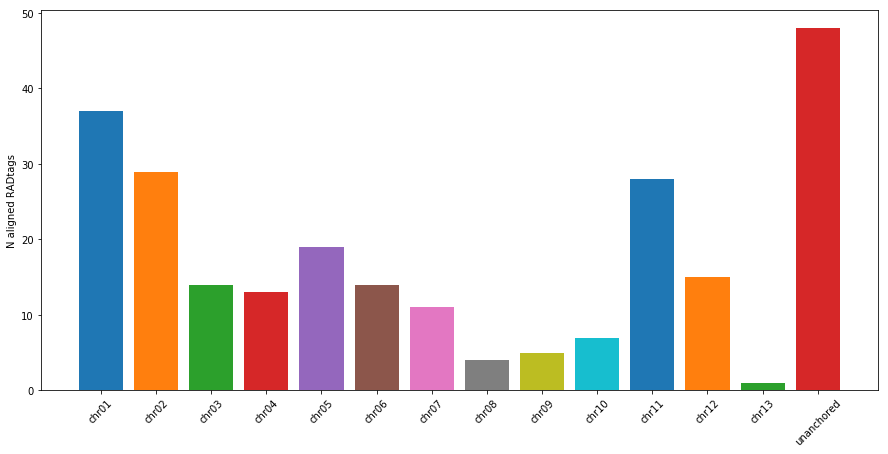

In [258]:
from matplotlib import pyplot as plt

plt.figure(figsize = (15,7))
x = 1
for i in sorted(align_dict.keys()):
    plt.bar(x, align_dict[i])
    plt.xticks(range(1,15), sorted(align_dict.keys()), rotation = 45)
    x += 1

plt.ylabel("N aligned RADtags")
plt.show()

Lets see how this looks against the chromosome lengths

In [246]:
from Bio import SeqIO

lengths = {}

genome = SeqIO.parse(open("/home/djeffrie/Data/Genomes/Rtemp_hybrid/Assembly/ALL_INC/Rtemp_all_scaffs.fasta", 'r'), "fasta")

for seq in genome:
    if "chr" in seq.id:
        lengths[seq.id] = len(seq.seq)
        
    

In [254]:
help(plt.legend)

Help on function legend in module matplotlib.pyplot:

legend(*args, **kwargs)
    Places a legend on the axes.
    
    To make a legend for lines which already exist on the axes
    (via plot for instance), simply call this function with an iterable
    of strings, one for each legend item. For example::
    
        ax.plot([1, 2, 3])
        ax.legend(['A simple line'])
    
    However, in order to keep the "label" and the legend element
    instance together, it is preferable to specify the label either at
    artist creation, or by calling the
    :meth:`~matplotlib.artist.Artist.set_label` method on the artist::
    
        line, = ax.plot([1, 2, 3], label='Inline label')
        # Overwrite the label by calling the method.
        line.set_label('Label via method')
        ax.legend()
    
    Specific lines can be excluded from the automatic legend element
    selection by defining a label starting with an underscore.
    This is default for all artists, so calling :meth:`leg

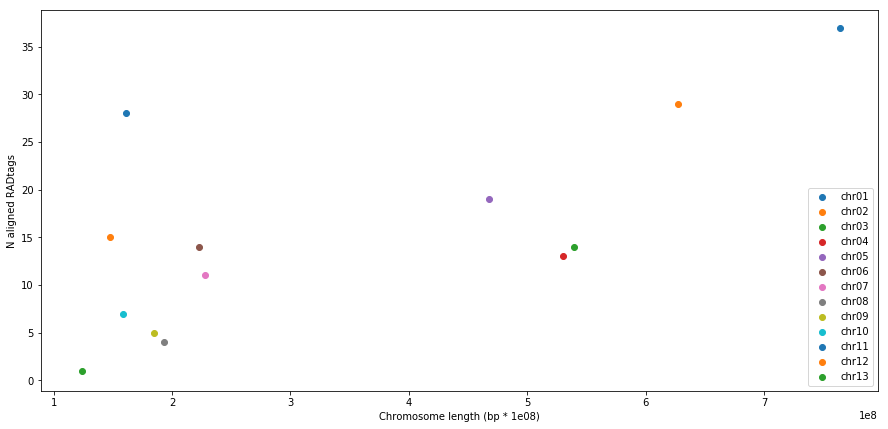

In [257]:
plt.figure(figsize = (15,7))

for i in sorted(align_dict.keys()):
    if i != "unanchored":
        plt.scatter(lengths[i], align_dict[i], label = i)
        
plt.legend(loc = "lower right")
plt.xlabel("Chromosome length (bp * 1e08)")
plt.ylabel("N aligned RADtags")
plt.show()

In [280]:
alignments = {}

for i in kept_alignments:
    chrom = i.split()[1]
    pos = i.split()[2]
    
    if "chr" in chrom:
        if chrom not in alignments:
            alignments[chrom] = []
        alignments[chrom].append(int(pos))
        


In [281]:
from matplotlib import pyplot as plt

In [299]:
help(plt.subplot)

Help on function subplot in module matplotlib.pyplot:

subplot(*args, **kwargs)
    Return a subplot axes positioned by the given grid definition.
    
    Typical call signature::
    
      subplot(nrows, ncols, plot_number)
    
    Where *nrows* and *ncols* are used to notionally split the figure
    into ``nrows * ncols`` sub-axes, and *plot_number* is used to identify
    the particular subplot that this function is to create within the notional
    grid. *plot_number* starts at 1, increments across rows first and has a
    maximum of ``nrows * ncols``.
    
    In the case when *nrows*, *ncols* and *plot_number* are all less than 10,
    a convenience exists, such that the a 3 digit number can be given instead,
    where the hundreds represent *nrows*, the tens represent *ncols* and the
    units represent *plot_number*. For instance::
    
      subplot(211)
    
    produces a subaxes in a figure which represents the top plot (i.e. the
    first) in a 2 row by 1 column notiona

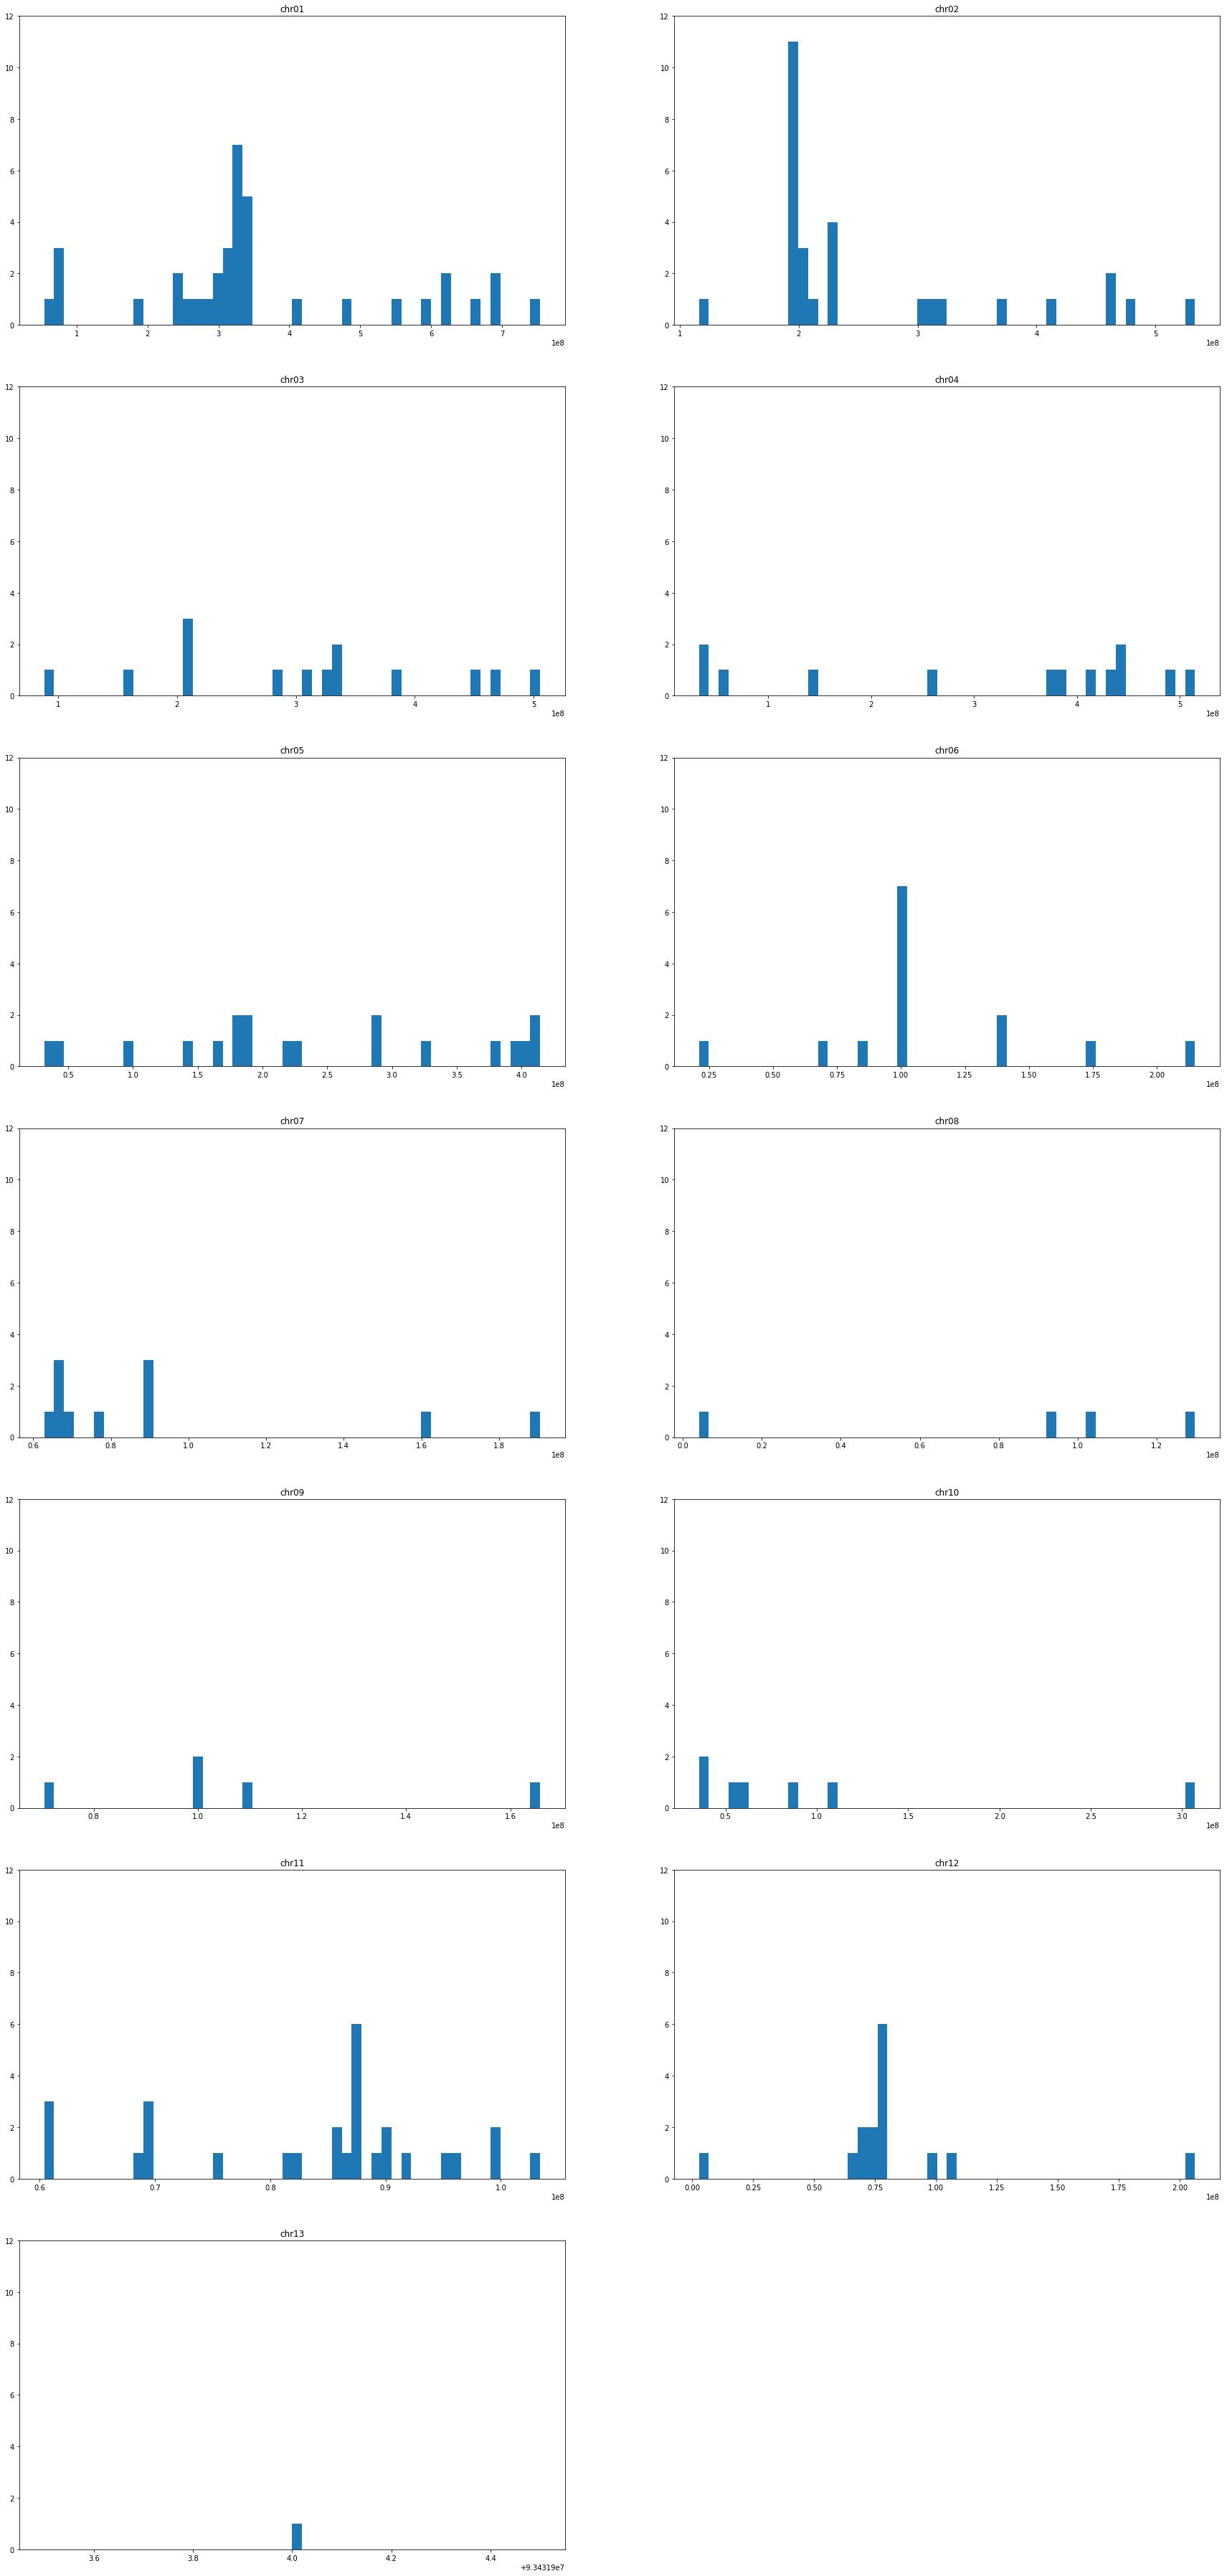

In [312]:
fig = plt.figure(figsize = (30,65))

plot_index = 1

for chrom in sorted(alignments.keys()):
    plt.subplot(7,2, plot_index)
    plt.hist(alignments[chrom], bins = 50)
    plt.title(chrom)
    plt.ylim(0,12)
    plot_index += 1
plt.show()